In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import csv

pd.options.display.max_rows = 10
pd.options.display.max_columns = 30
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# Mathcing exact word and not partials
import re

def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

In [4]:
songdf = pd.read_csv("/home/research/Documents/DeezerKeywordsDataset_v2.0/playlists_songs.tsv", 
                     delimiter = "\t", quoting=csv.QUOTE_NONE, error_bad_lines=False)
playlistsdf = pd.read_csv("/home/research/Documents/DeezerKeywordsDataset_v2.0/sample_playlists_title.tsv", 
                          delimiter = "\t", quoting=csv.QUOTE_NONE, error_bad_lines=False)

In [6]:
# Select playlists that contain keywords in their title
"""
Already found in matches column from Florian
"""

most_common_keywords = ["dance","chill","party","summer","relax","night","sad","gym","work","park",
                        "happy","club","running","workout","car","sleep","training","train","shower","morning"]
indices = pd.DataFrame(columns = ["playlist_id","keywords"])
for word in most_common_keywords:
    for index, row in playlistsdf.iterrows():
        #if word in row.title.lower():
        if findWholeWord(word)(row.title.lower()):
            indices = indices.append({'playlist_id': row.playlist_id, "keywords" : word},ignore_index = True)
playlist_20_common_keywords = playlistsdf[playlistsdf.playlist_id.isin(indices.playlist_id)]

In [15]:
#s = pd.Series([True, False, False, True, False], name='bools')
#playlistsdf = playlistsdf[["love" not in x for x in playlistsdf.matches]]

In [16]:
songs_top20_df = songdf.merge(indices,on='playlist_id',how='inner')
grouped_songs = songs_top20_df.groupby(['song_id','keywords']).count()
grouped_songs.reset_index(inplace=True)
grouped_songs.rename(columns={'playlist_id':'playlists_count'}, inplace = True)
songs_top20_df_filtered = grouped_songs[grouped_songs.playlists_count >= 3]
songs_IDs_20_common_keywords = songs_top20_df_filtered.song_id.unique()
with open ("/home/research/Documents/DeezerKeywordsDataset_v2.0/unique_songs_IDs_v2.0.csv", 'w') as fl: 
    for song_id in songs_IDs_20_common_keywords:
        fl.write(str(song_id)+"\n")
print("Found " + str(len(songs_IDs_20_common_keywords)) + 
      " songs existing in at least 3 contextual playlists that contain common context keyword")

Found 66075 songs existing in at least 3 contextual playlists that contain common context keyword


In [17]:
# check the format of a selected song
SelectedSong = 1
print(grouped_songs[grouped_songs.song_id == songs_IDs_20_common_keywords[SelectedSong]])
print("\ncheck the song webpage on: \n" + "https://www.deezer.com/en/track/" + str(songs_IDs_20_common_keywords[SelectedSong]))

    song_id keywords  playlists_count
11   204074     club                6
12   204074    dance               37
13   204074      gym                3
14   204074  morning                1
15   204074    night                2
16   204074    party                4
17   204074   summer                1
18   204074     work                2
19   204074  workout                1

check the song webpage on: 
https://www.deezer.com/en/track/204074


In [22]:
# check which playlists it existed
song_playlists = songs_top20_df[songs_top20_df.song_id == songs_IDs_20_common_keywords[SelectedSong]]
song_playlists

playlist_id  song_id keywords
12158      43641617   204074    dance
12191      68927235   204074    dance
39151      38807899   204074     club
41638    1099519211   204074    dance
77063      46984042   204074      gym
...             ...      ...      ...
2369881    17114672   204074    dance
2385896  1028037731   204074     work
2439318    28306008   204074    dance
2522721    41367159   204074    dance
2536798    68492505   204074    dance

[57 rows x 3 columns]

In [23]:
# check a specific playlists that contained the selected track
selected_playlist = 2
selected_playlist_id = playlist_20_common_keywords[playlist_20_common_keywords.playlist_id == 
                            song_playlists.playlist_id.iloc[selected_playlist]]
print(selected_playlist_id)
print("\ncheck the playlist webpage on: \n" + "https://www.deezer.com/en/playlist/" 
      + str(int(selected_playlist_id.playlist_id)))

      playlist_id  editor           title matches
1562     38807899       0  version club !    club

check the playlist webpage on: 
https://www.deezer.com/en/playlist/38807899


## editing the dataset as one-hot vector format

In [24]:
songs_top20_df_filtered_hot_encoded = pd.concat([songs_top20_df_filtered,
                pd.get_dummies(songs_top20_df_filtered['keywords'])],
               axis=1).drop(['keywords'],axis=1)

In [25]:
songs_top20_df_filtered_track_count_encoded = songs_top20_df_filtered_hot_encoded.copy()

In [26]:
songs_top20_df_filtered_track_count_encoded.iloc[:,2:] = \
    songs_top20_df_filtered_track_count_encoded.iloc[:,2:].mul(
    songs_top20_df_filtered_track_count_encoded.playlists_count.values, axis="index")

In [28]:
#songs_top20_df_filtered_track_count_encoded

In [29]:
# Remove any annotation of labels occuring less than 3 times
songs_top20_df_filtered_track_count_encoded.replace([1, 2],0,inplace=True)

In [30]:
songs_top20_df_filtered_track_count_encoded_grouped = songs_top20_df_filtered_track_count_encoded.groupby('song_id').sum()
songs_top20_df_filtered_track_count_encoded_grouped.reset_index(inplace = True)

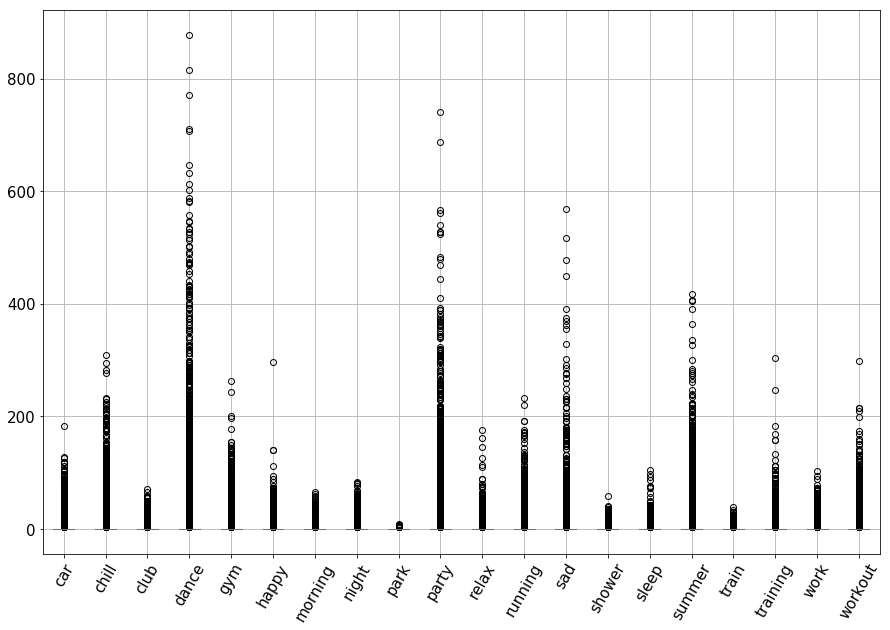

In [31]:
boxplot = songs_top20_df_filtered_track_count_encoded.boxplot(column=['car', 'chill', 'club', 
          'dance', 'gym','happy', 'morning', 'night', 'park', 'party', 'relax', 'running', 'sad',
          'shower', 'sleep', 'summer', 'train', 'training', 'work', 'workout'], rot=60, fontsize=15, 
          figsize = [15,10])

In [32]:
boxplot.figure.savefig("/home/research/Documents/Figures/playlists_count_v2.0.png",
        dpi=300, format="png")
boxplot.figure.savefig("/home/research/Documents/Figures/playlists_count_v2.0.pdf",
        dpi=300, format="pdf")
boxplot.figure.savefig("/home/research/Documents/Figures/playlists_count_v2.0.eps",
        dpi=300, format="eps") 

In [33]:
songs_top20_df_filtered_track_count_encoded_grouped.describe()

song_id  playlists_count      car    chill     club    dance  \
count     66075.00         66075.00 66075.00 66075.00 66075.00 66075.00   
mean  152378841.69            26.44     1.13     3.54     0.37     5.46   
std   178470546.67            89.97     5.12    10.49     2.20    22.80   
min      200756.00             3.00     0.00     0.00     0.00     0.00   
25%    13162924.00             3.00     0.00     0.00     0.00     0.00   
50%    81656608.00             6.00     0.00     0.00     0.00     0.00   
75%   142745755.00            17.00     0.00     4.00     0.00     4.00   
max   653159322.00          3488.00   182.00   309.00    71.00   878.00   

           gym    happy  morning    night     park    party    relax  running  \
count 66075.00 66075.00 66075.00 66075.00 66075.00 66075.00 66075.00 66075.00   
mean      1.42     0.55     0.21     0.58     0.00     4.46     1.01     1.12   
std       6.38     3.36     1.66     2.77     0.13    18.12     4.05     5.82   
min       0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
25%       0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
50%       0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
75%       0.00     0.00     0.00     0.00     0.00     3.00     0.00     0.00   
max     263.00   296.00    66.00    83.00     9.00   740.00   176.00   233.00   

           sad   shower    sleep   summer    train  training     work  workout  
count 66075.00 66075.00 66075.00 66075.00 66075.00  66075.00 66075.00 66075.00  
mean      1.05     0.22     0.35     1.84     0.13      0.72     0.94     1.31  
std       8.96     1.54     2.29    10.19     0.98      4.09     3.70     6.56  
min       0.00     0.00     0.00     0.00     0.00      0.00     0.00     0.00  
25%       0.00     0.00     0.00     0.00     0.00      0.00     0.00     0.00  
50%       0.00     0.00     0.00     0.00     0.00      0.00     0.00     0.00  
75%       0.00     0.00     0.00     0.00     0.00      0.00     0.00     0.00  
max     569.00    58.00   105.00   417.00    38.00    304.00   102.00   299.00

In [34]:
# What is the most popular track?
most_popular_song = songs_top20_df_filtered_track_count_encoded_grouped[
    songs_top20_df_filtered_track_count_encoded_grouped.playlists_count 
    == songs_top20_df_filtered_track_count_encoded_grouped.playlists_count.max()]
display(most_popular_song)
print("\ncheck the playlist webpage on: \n" + "https://www.deezer.com/en/track/" 
      + str(int(most_popular_song.song_id)))

song_id  playlists_count  car  chill  club  dance  gym  happy  \
48488  139470659             3488  182    294    27    633  201    140   

       morning  night  park  party  relax  running  sad  shower  sleep  \
48488       50     82     3    740     80      220   31      58     31   

       summer  train  training  work  workout  
48488     327     38        80   102      169


check the playlist webpage on: 
https://www.deezer.com/en/track/139470659


In [35]:
# Most labeled song in certain context [in this case "Dance"]
most_labeled_songs = songs_top20_df_filtered_track_count_encoded_grouped[songs_top20_df_filtered_track_count_encoded_grouped.dance == songs_top20_df_filtered_track_count_encoded_grouped.dance.max()]
display(most_labeled_songs)
print("\ncheck the playlist webpage on: \n" + "https://www.deezer.com/en/track/" 
      + str(int(most_labeled_songs.song_id)))

song_id  playlists_count  car  chill  club  dance  gym  happy  \
25285  66609426             2449   52     76    54    878   94    111   

       morning  night  park  party  relax  running  sad  shower  sleep  \
25285       20     83     6    561     46      113    0      15      5   

       summer  train  training  work  workout  
25285     168     18        29    60       60


check the playlist webpage on: 
https://www.deezer.com/en/track/66609426


In [36]:
# Is park still buggy from Linkin Park?
most_labeled_song_as_park = songs_top20_df_filtered_track_count_encoded_grouped[songs_top20_df_filtered_track_count_encoded_grouped.park == songs_top20_df_filtered_track_count_encoded_grouped.park.max()]
display(most_labeled_song_as_park)
print("\ncheck the track webpage on: \n" + "https://www.deezer.com/en/track/" 
      + str(int(most_labeled_song_as_park.song_id)))

song_id  playlists_count  car  chill  club  dance  gym  happy  morning  \
1601   677232              623   46     44     0     37   84      9        5   

      night  park  party  relax  running  sad  shower  sleep  summer  train  \
1601      9     9     42     14       58   47       3      8      11     12   

      training  work  workout  
1601        89    31       65


check the playlist webpage on: 
https://www.deezer.com/en/track/677232


In [37]:
songs_top20_df_filtered_track_count_encoded_grouped = songs_top20_df_filtered_track_count_encoded.groupby('song_id').sum()
songs_top20_df_filtered_track_count_encoded_grouped.reset_index(inplace = True)

songs_top20_df_filtered_hot_encoded_grouped = songs_top20_df_filtered_hot_encoded.groupby('song_id').sum()
songs_top20_df_filtered_hot_encoded_grouped.reset_index(inplace = True)

In [41]:
#Saving ground truth data
import os
Saving_PATH = "/home/research/Documents/GroundTruth/v2.0"

songs_top20_df_filtered_hot_encoded_grouped.to_pickle(os.path.join(
    Saving_PATH,"ground_truth_hot_vector.pkl"))
songs_top20_df_filtered_track_count_encoded_grouped.to_pickle(os.path.join(
    Saving_PATH,"ground_truth_track_count_vector.pkl"))

In [49]:
current_specs = os.listdir("/home/research/Documents/MelSpectograms_top20/")
current_specs = [x.split('.')[0] for x in current_specs]

In [64]:
unmatched_song_ids = [x for x in list(songs_top20_df_filtered_hot_encoded_grouped.song_id) if str(x) not in current_specs]

In [65]:
len(unmatched_song_ids)

32239

In [63]:
unmatched_song_ids

int

In [67]:
with open ("/home/research/Documents/DeezerKeywordsDataset_v2.0/unique_songs_IDs_v2.0[mel_uncomputed].csv", 'w') as fl: 
    for song_id in unmatched_song_ids:
        fl.write(str(song_id)+"\n")

In [83]:
predictions_count = [list(songs_top20_df_filtered_hot_encoded_grouped.iloc[:,2:].sum())]
class_preds_per_context = pd.DataFrame(predictions_count,columns=
                                       songs_top20_df_filtered_hot_encoded_grouped.columns[2:])

In [84]:
class_preds_per_context

car  chill  club  dance    gym  happy  morning  night  park  party  relax  \
0  8571  23719  3658  26407  10148   4736     2017   5740    79  22776   8696   

   running   sad  shower  sleep  summer  train  training  work  workout  
0     7625  6271    2332   3261   10966   1653      6191  8465     8413